# Data Modeling

## Importing Packages

In [111]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import random
import numpy as np
import pickle
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import copy
def load_obj(name ):                    
    with open('' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

### Function for LOSOCV

In [59]:
def losocv(X, y, model):
    '''
    X: feature matrix
    y: target value
    model: model evaluated
    Returns average MSE across all folds of LOSOCV
    '''
    X['patient'] = list(range(1,18))*3 #adding patient column for ease of test/train split
    X['response'] = y
    res = []
    for i in list(range(1,18)):
        ytrain = X.loc[X['patient']!=i]['response']
        Xtrain = X.loc[X['patient']!=i].drop(['patient','response'], axis=1) 
        ytest = X.loc[X['patient']==i]['response']
        Xtest = X.loc[X['patient']==i].drop(['patient','response'], axis=1) 
        model.fit(Xtrain, ytrain)
        predictions = model.predict(Xtest)
        res.append(mean_squared_error(ytest, predictions))
    return np.mean(res)

### Function for Parameter Tuning

In [90]:
def findParameters(model, grid, X, y):
    '''
    model: model to be tuned
    grid: grid of potential parameters
    X: feature matrix
    y: response value
    Returns optimal parameters and the corresponding MSE
    '''
    mselist = []
    grids = []
    for g in ParameterGrid(grid):
            rf = model(**g)
            mse = losocv(X, y, rf)
            if len(mselist) == 0:
                mselist.append(mse)
                bestMSE = mse
                bestParams = g
                continue
            if mse < bestMSE:
                bestMSE = mse
                bestParams = g
            mselist.append(mse)
            grids.append(g)
    return {'params': bestParams, 'mse':bestMSE}


In [60]:
datasets = load_obj('datasets_selected')
response = load_obj('response')

## Random Forest

In [91]:
X = copy.deepcopy(datasets['plasmaluminex'])

In [92]:
y = copy.deepcopy(response)

In [102]:
resultsRF = {}
grid = {
        "n_estimators" : [10,50,100],
        "max_features" : ["auto", "log2", "sqrt"],
        "bootstrap"    : [True, False]
    }
model = RandomForestRegressor
for name in datasets:
    X = datasets[name]
    res = findParameters(model,grid, X, y)
    print('The best MSE for the {} dataset was {}'.format(name, res['mse']))
    resultsRF[name] = [res['mse'], res['params']]

The best MSE for the cellfreerna dataset was 32.3497573824165
The best MSE for the plasmaluminex dataset was 27.02873333333333
The best MSE for the serumluminex dataset was 36.61530283224401
The best MSE for the microbiome dataset was 12.01131096927197
The best MSE for the immunesystem dataset was 32.49854117647059
The best MSE for the metabolomics dataset was 14.710556862745097
The best MSE for the plasmasomalogic dataset was 14.844565795206968


## XGBoost

In [85]:
grid = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [3, 4]
        }
model = XGBRegressor
findParameters(model,grid)

{'params': {'colsample_bytree': 0.8,
  'gamma': 5,
  'max_depth': 3,
  'min_child_weight': 5,
  'subsample': 0.6},
 'mse': 25.408235026982798}

In [114]:
resultsXGB = {}
grid = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [3, 4]
        }
model = XGBRegressor
for name in datasets:
    X = datasets[name]
    res = findParameters(model,grid, X, y)
    print('The best MSE for the {} dataset was {}'.format(name, res['mse']))
    resultsXGB[name] = [res['mse'], res['params']]

The best MSE for the cellfreerna dataset was 26.90928514996688
The best MSE for the plasmaluminex dataset was 25.473804952453495
The best MSE for the serumluminex dataset was 37.26933343312944
The best MSE for the microbiome dataset was 10.929919872716264
The best MSE for the immunesystem dataset was 34.32594336631174
The best MSE for the metabolomics dataset was 12.206506693415506
The best MSE for the plasmasomalogic dataset was 17.773059525617228


## Visualizations

In [139]:
names = list(resultsRF.keys())
mses = [resultsRF[x][0] for x in resultsRF.keys()]

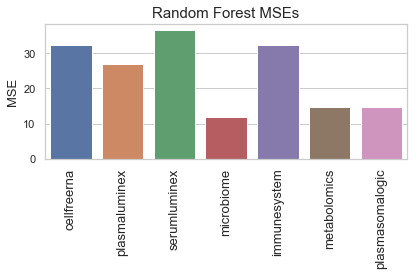

In [140]:
sns.set(style="whitegrid")
ax = sns.barplot(x=names, y=mses)
plt.title('Random Forest MSEs',fontsize=15)
plt.ylabel('MSE',fontsize=13)
plt.xticks(rotation=90, fontsize=13)
plt.tight_layout()
plt.savefig('rfmse')

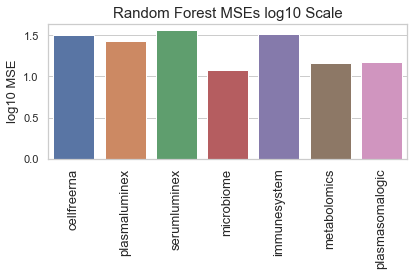

In [141]:
sns.set(style="whitegrid")
ax = sns.barplot(x=names, y=np.log10(mses))
plt.title('Random Forest MSEs log10 Scale',fontsize=15)
plt.ylabel('log10 MSE',fontsize=13)
plt.xticks(rotation=90, fontsize=13)
plt.tight_layout()
plt.savefig('rfmselog10')

In [142]:
names = list(resultsXGB.keys())
mses = [resultsXGB[x][0] for x in resultsXGB.keys()]

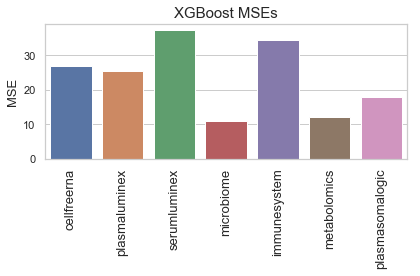

In [143]:
sns.set(style="whitegrid")
ax = sns.barplot(x=names, y=mses)
plt.title('XGBoost MSEs',fontsize=15)
plt.ylabel('MSE',fontsize=13)
plt.xticks(rotation=90, fontsize=13)
plt.tight_layout()
plt.savefig('xgbmse')

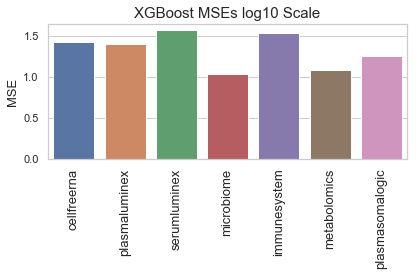

In [144]:
sns.set(style="whitegrid")
ax = sns.barplot(x=names, y=np.log10(mses))
plt.title('XGBoost MSEs log10 Scale',fontsize=15)
plt.ylabel('MSE',fontsize=13)
plt.xticks(rotation=90, fontsize=13)
plt.tight_layout()
plt.savefig('xgbmselog10')